# Demonstration: Point Defect Formation Energy

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2015-08-28

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This notebook was tested with:

- LAMMPS (Version 2015-03-27)

- Python (Version 2.7.6)

- IPython (Version 2.0.0)

- - -

## Introduction

This Notebook calculates the formation energy of different point defects.  To do so, various system sizes are explored and the energy values are extrapolated to infinite atom systems. 

Related calculations:

- tool-Vacancy-Mobility: computes the vacancy mobility pathway and energy barrier.


- - -

##1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Necessary Parameters__: These are the parameters that need to be specified to run the code.

3. __Calculation Parameters__: These are user-specified parameters that control how the calculation proceeds, such as number of data points.

###1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code.

- Numpy can be found [here](http://www.numpy.org/).

- Matplotlib can be found [here](http://matplotlib.org/).

- iprp is contained in the IPR code download.

In [1]:
#Standard Python Libraries
import subprocess
import os
from copy import deepcopy
import sys

#Additional Python Libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#Custom package
import atomman as am

###1.2 Necessary Parameters

These are the parameters that need to be specified to run the code.

- lammps_exe is the directory location for the LAMMPS executable to use.

- working_dir is the working directory where you want this Notebook to run.

- pot_file is the name (and location) of the interatomic potential data model file associated with the potential you want to use. A default potential (Al-Si-Mg-Cu-Fe--JelinekB--2012) is embedded in Section 2.1 of this Notebook, and the associated interatomic potential data model file is embedded in Section 2.2. Other potentials and interatomic potential data models can be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

- pot_dir is the directory location where any potential artifacts (i.e. eam setfl, meam library files) are located.

- proto_file is the name (and location) of a crystal prototype data model file. These files contain sets of parameters associated with generating different crystal prototypes. One example (fcc.json) is embedded in Section 2.3. Other crystal prototype data models can be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/). 

- elements is a list of the elements to be associated with the unique lattice sites of the selected crystal prototype. Elemental prototypes (eg. fcc) will need only one element, while compounds (eg. CsCl) require multiple elements.

- alat is an array of the three lattice parameters.  

- ptd_file is the name (and location) of a point defect library data model file.  These files contain parameters associated with generating different point defects. One example (fcc-ptd.json) is embedded in Section 2.4. Other point defect library data models can be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/). 

In [2]:
#Specify LAMMPS run command
lammps_exe = 'C:\\users\\lmh1\\Documents\\lmp_serial.exe'

#Specify working directory
working_dir = 'tool-Point-Defect'
try:
    os.chdir(working_dir)
except:
    os.mkdir(working_dir)
    os.chdir(working_dir)
working_dir = os.getcwd()

#Specify interatomic potential data model file
potential_file = 'Al-Si-Mg-Cu-Fe--JelinekB--2012.json'

#Specify path to potential artifacts, (eam setfl file, meam library files, etc.)
potential_dir = working_dir

#Specify crystal prototype data model file
prototype_file = 'fcc.json'

#List the element symbol(s) to use
symbols = ['AlS']

#Give the lattice parameters
a = b = c = 4.0500
alpha = beta = gamma = 90.0

#Specify point defect library data model file
point_defects_file = 'fcc-ptd.json'

###1.3 Calculation Parameters

These are user-specified parameters that control how the calculation proceeds, such as number of data points.

- ptd_list is a list of the tags that identify the different types of point defects. 

- min_size and max_size are the minimum and maximum system sizes to be explored.

__Note:__ The point defect configurations contained in the point defect libraries may not be fully inclusive of all defect structures.  As such, the true low energy configurations may be of a different nature.

In [3]:
#Supply a list of defects to include in the analysis
#point_defect_tags = ['vac', '1nn', '2nn']                      #vacancy and di-vacancies
point_defect_tags = ['oct', 'tet', 'cro', '100', '110', '111']  #interstitials

#Specify the minimum and maximum system sizes (need to be even integers)
min_size = 4
max_size = 10

##2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

4. __Point Defect Library Data Model.__ Collects input parameters associated with generating a number of different point defects.

###2.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__Al-Si-Mg-Cu-Fe--JelinekB--2012__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation. 

In [4]:
#Create MEAM library and parameter files for the Al-Si-Mg-Cu-Fe--JelinekB--2012 potential
   
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

###2.2 Potential Data Model

This generates the interatomic potential data model file associated with the Al-Si-Mg-Cu-Fe--JelinekB--2012 potential.  Additional interatomic potential data model files can also be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

In [5]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
f = open('Al-Si-Mg-Cu-Fe--JelinekB--2012.json', 'w')
f.write("""{
    "interatomicPotentialImplementationLAMMPS": {
        "potentialID": {
            "descriptionIdentifier": "Al-Si-Mg-Cu-Fe--JelinekB--2012"
        },
        "units": "metal",
        "atom_style": "atomic",
        "atom": [
            {
                "element": "Al",
                "symbol": "AlS"
            },
            {
                "element": "Si",
                "symbol": "SiS"
            },
            {
                "element": "Mg",
                "symbol": "MgS"
            },
            {
                "element": "Cu",
                "symbol": "CuS"
            },
            {
                "element": "Fe",
                "symbol": "FeS"
            }
        ],
        "pair_style": {
            "type": "meam"
        },
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                },
                {
                    "symbolsList": "True"
                },
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                },
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

###2.3 Prototype Data Model

This generates the crystal prototype data model file associated with the fcc crystal prototype.  Additional crystal prototype data model files can also be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

In [6]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
f = open('fcc.json', 'w')
f.write("""{
    "crystalPrototype": {
        "crystalProtoypeID": { 
            "common": "face-centered cubic", 
            "tag": "fcc",
            "prototype": "Cu",
            "Strukturbericht": "A1"
        },            
        "crystalProtoypeInfo": { 
            "PearsonSymbol": "cF4",
            "spaceGroupTag": "F m -3 m",
            "SpaceGroupNumber": 225
        },
        "lattice": {
            "cubic": {
                "atomPositions": {
                    "site": {
                        "component": 1,
                        "atomCoordinates": [
                            {
                                "value": [0.0000000000000, 0.0000000000000, 0.0000000000000],
                                "unit": "scaled"
                            },                      
                            {
                                "value": [0.5000000000000, 0.5000000000000, 0.0000000000000],
                                "unit": "scaled"
                            },
                            {
                                "value": [0.5000000000000, 0.0000000000000, 0.5000000000000],
                                "unit": "scaled"
                            },
                            {
                                "value": [0.0000000000000, 0.5000000000000, 0.5000000000000],
                                "unit": "scaled"
                            }
                        ]
                    }
                }
            }
        }
    }
}""")
f.close()

###2.4 Point Defect Library Data Model

This generates the point defect library data model file associated with point defects in the fcc crystal. Additional point defect library data model files can also be downloaded from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/).

In [7]:
#Creates an instance of a point defect library data model for generating point defects.
f = open('fcc-ptd.json', 'w')
f.write("""{
    "pointDefectList": {
        "crystalPrototype": "fcc",
        "pointDefect": [
            {
                "pointDefectID": {
                    "tag": "vac",
                    "name": "vacancy"
                },
                "parameters": {
                    "defectType": "v",
                    "coordinates": {
                        "value": [0.0000000000000, 0.0000000000000, 0.0000000000000],
                        "units": "scaled"
                    }    
                }
            },
            {
                "pointDefectID": {
                    "tag": "1nn",
                    "name": "1nn_divacancy"
                },
                "parameters": [
                    {
                        "defectType": "v",
                        "coordinates": {
                            "value": [0.0000000000000, 0.0000000000000, 0.0000000000000],
                            "units": "scaled"
                        }
                    },
                    {
                        "defectType": "v",
                        "coordinates": {
                            "value": [0.0000000000000, 0.5000000000000, 0.5000000000000],
                            "units": "scaled"
                        }
                    }
                ]
            },
            {
                "pointDefectID": {
                    "tag": "2nn",
                    "name": "2nn_divacancy"
                },
                "parameters": [
                    {
                        "defectType": "v",
                        "coordinates": {
                            "value": [0.0000000000000, 0.0000000000000, 0.0000000000000],
                            "units": "scaled"
                        }
                    },
                    {
                        "defectType": "v",
                        "coordinates": {
                            "value": [0.0000000000000, 0.0000000000000, 1.0000000000000],
                            "units": "scaled"
                        }
                    }
                ]
            },
            {
                "pointDefectID": {
                    "tag": "oct",
                    "name": "octahedral"
                },
                "parameters": {
                    "defectType": "i",
                    "atype": 1,
                    "coordinates": {                        
                        "value": [0.5000000000000, 0.5000000000000, 0.5000000000000],
                        "units": "scaled"
                    }
                }
            },
            {
                "pointDefectID": {
                    "tag": "tet",
                    "name": "tetrahedral"
                },
                "parameters": {
                    "defectType": "i",
                    "atype": 1,
                    "coordinates": {
                        "value": [0.2500000000000, 0.2500000000000, 0.2500000000000],
                        "units": "scaled"
                    }
                }
            },
            {
                "pointDefectID": {
                    "tag": "cro",
                    "name": "crowdion"
                },
                "parameters": {
                    "defectType": "i",
                    "atype": 1,
                    "coordinates": {
                        "value": [0.2500000000000, 0.2500000000000, 0.0000000000000],
                        "units": "scaled"
                    }
                }
            },
            {
                "pointDefectID": {
                    "tag": "100",
                    "name": "100dumbbell"
                },
                "parameters": {
                    "defectType": "db",
                    "atype": 1,
                    "dumbbellVector": {
                        "value": [0.0000000000000, 0.0000000000000, 0.3333333333333],
                        "units": "scaled"
                    }
                }
            },
            {
                "pointDefectID": {
                    "tag": "110",
                    "name": "110dumbbell"
                },
                "parameters": {
                    "defectType": "db",
                    "atype": 1,
                    "dumbbellVector": {
                        "value": [0.0000000000000, 0.2500000000000, 0.2500000000000],
                        "units": "scaled"
                    }
                }
            },
            {
                "pointDefectID": {
                    "tag": "111",
                    "name": "111dumbbell"
                },
                "parameters": {
                    "defectType": "db",
                    "atype": 1,
                    "dumbbellVector": {
                        "value": [0.2500000000000, 0.2500000000000, 0.2500000000000],
                        "units": "scaled"
                    }
                }
            }
        ]
    }
}""")
f.close()

##3. LAMMPS Script Generation Function(s)

This code generates the underlying LAMMPS script(s) for performing the necessary simulations. For all scripts, system_info and pair_info are required.  system_info is the LAMMPS script lines associated with either generating or reading in atomic system information.  pair_info is the LAMMPS script lines that assigns the atomic interaction model information.  

- min_script() performs an energy minimization on a system. The function allows for the minimization parameters to be controlled. 

In [8]:
def min_script(system_info, pair_info, etol = 0, ftol = 1e-6, maxiter = 100000, maxeval = 100000):
    #Perform energy minimization on atoms in file read_data using potential information from all other parameters
    nl = '\n'
    script = nl.join([system_info,
                      '',
                      pair_info,
                      '',
                      'variable peatom equal pe/atoms',
                      '',
                      'thermo_style custom step lx pxx pe v_peatom',
                      'thermo_modify format float %.13e',
                      '',
                      'dump dumpit all custom %i atom.* id type x y z'%(maxeval),
                      'dump_modify dumpit format "%i %i %.13e %.13e %.13e"',
                      'minimize %f %f %i %i'%(etol, ftol, maxiter, maxeval)])
    return script

##4. Python Calculation Function(s)

These functions are associated with setting up the atomic systems, running LAMMPS, extracting the simulation data, and refining the results.

- ptd_energy() computes the formation energy associated with a particular type of point defect for different system sizes.  The function returns the total number of atoms, the formation energies, and two parameters related to defining if the system has transformed for each size.  

In [9]:
def point_defect_Ef(lammps_exe, ucell, potential, symbols, point_defect_params, min_size, max_size):
#Calculate the formation energy for a point defect
    
    if min_size%2 == 1 or max_size%2 == 1:
        raise ValueError('min_size and max_size must be even')
        
    #Parameter setup
    sizes =    range(min_size, max_size+2, 2)
    natoms =   np.zeros(len(sizes))
    energies = np.zeros(len(sizes))
    centro =   np.zeros((len(sizes),3))
    rcoord =   np.zeros((len(sizes),3))
    
    pair_info = potential.pair_info(symbols)
    
    if len(point_defect_params) == 1:
        shift = True
    else:
        shift = False
    
    #For all system sizes
    for i in xrange(len(sizes)):    
        #Construct perfect system
        h = sizes[i]/2
        system_info = am.lammps.sys_gen(units =       potential.units(),
                                        atom_style =  potential.atom_style(),
                                        ucell_box =   ucell.box(),
                                        ucell_atoms = ucell.atoms(scale=True),
                                        size =        np.array([[-h,h], [-h,h], [-h,h]], dtype=np.int) )
                                           
        
        
        with open('min.in','w') as script:
            script.write( min_script(system_info, pair_info) )
        data = am.lammps.log_extract(subprocess.check_output(lammps_exe + ' -in min.in', shell=True))
        
        sys0 = am.lammps.read_dump('atom.' + data[-1][0])
        pnatoms = sys0.natoms()
        ecoh = float(data[-1][4])
        
        #Construct defect system
        dsys = deepcopy(sys0)
        psys = None
        for params in point_defect_params:
            if params['pos'] is None:
                pos = ucell.unscale(np.array([0.1, 0.1, 0.1]))
            else:
                pos = ucell.unscale(params['pos'] + np.array([0.1, 0.1, 0.1]))
                
            if params['d'] is None:
                db_vect = None
            else:
                db_vect = ucell.unscale(params['d'])
                
            psys, dsys = dsys.pt_defect(ptdtype = params['ptdtype'], 
                                        atype =   params['atype'], 
                                        pos =     pos, 
                                        db_vect = db_vect,
                                        shift =   shift)                                        
            
        natoms[i] = dnatoms = dsys.natoms()
            
        #Run LAMMPS, record formation energy and obtain relaxed system
        system_info = am.lammps.write_data('def.dat', dsys)
        
        with open('min.in','w') as script:
            script.write( min_script(system_info, pair_info) )
        data = am.lammps.log_extract(subprocess.check_output(lammps_exe + ' -in min.in', shell=True))
        
        energies[i] = float(data[2][3]) - ecoh * dnatoms
        dsys_r = am.lammps.read_dump('atom.' + data[2][0])
        
        try:
            os.rename('atom.'+data[2][0], str(sizes[i]) + '.dump')
        except:
            os.remove(str(sizes[i]) + '.dump')
            os.rename('atom.'+data[2][0], str(sizes[i]) + '.dump')

        #Perform structure test calculations if only one defect was added
        if len(point_defect_params) == 1:
            
            #Compute centrosummation of atoms near defect. 
            nids = []
            for k in xrange(dnatoms):
                if k >= pnatoms:
                    nids.append(k)
                elif mag(psys.atoms(k, 'pos')) < ucell.box('a') * 1.05:
                    nids.append(k)
            #Sum up positions (using relaxed defect system) of selected atoms
            for k in nids:
                centro[i] += dsys_r.atoms(k, 'pos')
        
            #check position of interstitial and substitutional atoms after relaxing
            if ptd_params[0]['ptdtype'] == 'i' or ptd_params[0]['ptdtype'] == 's':
                last = dnatoms - 1
                rcoord[i] = dsys.dvect(last, dsys_r.atoms(last))
            #check dumbbell vector directions after relaxing   
            elif ptd_params[0]['ptdtype'] == 'db':
                last = dnatoms - 1
                dcheck = dsys_r.dvect(last, last-1)
                d_init = ptd_params[0]['d']
                rcoord1 = dcheck/mag(dcheck)
                rcoord2 = d_init/mag(d_init)
                rcoord[i] = rcoord1 - rcoord2
    
    return natoms, energies, centro, rcoord    
    
#Returns the magnitude of a vector
def mag(vector):
    magval = 0.0
    for term in vector:
        magval += term**2.
    return magval ** 0.5   

##5. Run Calculation and Display Results

This is the code that runs the calculation function(s) for the supplied inputs and displays the resulting data.

octahedral   :  3.272 eV
tetrahedral  :  3.328 eV
crowdion     :  2.859 eV
100dumbbell  :  Unstable
110dumbbell  :  Unstable
111dumbbell  :  Unstable


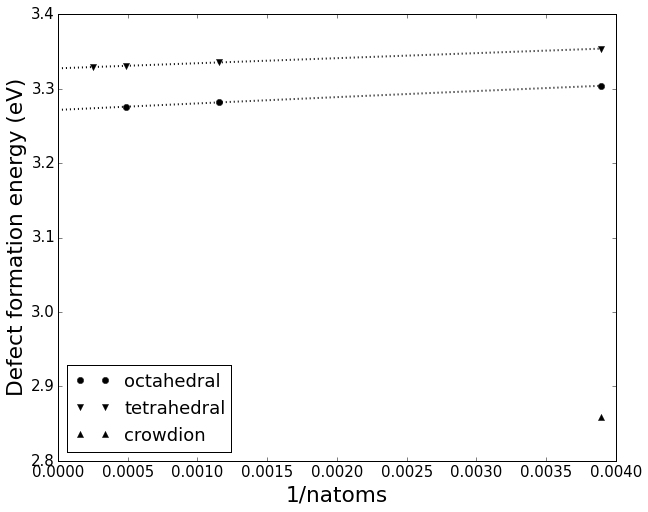

In [10]:
#Read the data model files
potential = am.lammps.Potential(potential_file, potential_dir)
prototype = am.tools.Prototype(prototype_file)
point_defect_lib = am.tools.PointDefect(point_defects_file)

ucell = prototype.ucell(a=a, b=b, c=c, alpha=alpha, beta=beta, gamma=gamma)
#Count how many atoms are at each prototype site
quants = np.zeros(ucell.natypes(), dtype=np.int)
for i in xrange(ucell.natoms()):
    quants[ucell.atoms(i, 'atype') - 1] += 1
    
#Compose structure name by combining crystal prototype and composition
elements = potential.elements(symbols)
structure = prototype.get('tag') + ' '
for i in xrange(len(elements)):
    structure += elements[i]
    if quants[i] > 1:
        structure += str(quants[i])

#Initialize plot
if max_size > min_size:
    matplotlib.rc('lines',lw=2)
    matplotlib.rc('font',size=15)
    plt.figure(figsize=(10,8))
    markers = ['ko','kv','k^','k<','k>','ks','k*','kp','kH','kD','k+','kx']

#Loop over all defects in ptd_list
m = 0    
for defect in point_defect_tags:
    ptd_tag = ''
    for tag in point_defect_lib.get('list'):
        if defect == tag:
            ptd_tag = tag
            ptd_params = point_defect_lib.get(tag,'parameters')
            ptd_name = point_defect_lib.get(tag,'name')
            break
    if ptd_tag == '':
        raise ValueError('Defect type ' + defect + ' not found')
              
    #Run ptd_energy calculation
    natoms, energies, centro, rcoord = point_defect_Ef(lammps_exe, ucell, potential, symbols, 
                                                       ptd_params, min_size, max_size)
    
    #Make list of energies for stable defect systems
    invatoms_list = []
    energies_list = []
    for i in xrange(len(natoms)): 
        if (np.allclose(centro[i], np.zeros(3), rtol=0, atol=1e-3) and
            np.allclose(rcoord[i], np.zeros(3), rtol=0, atol=1e-3)):
            invatoms_list.append(1./natoms[i])
            energies_list.append(energies[i])
            
    #If no stable energies are found
    if len(energies_list)==0:
        defect_energy = 'Unstable'
    
    #If one stable energy is found
    elif len(energies_list)==1:
        defect_energy = '%5.3f eV' % energies_list[0]
        if max_size > min_size:
            plt.plot(invatoms_list, energies_list, markers[m], label=ptd_name)
    
    #If two stable energies are found
    elif len(energies_list)==2:
        xlist = np.linspace(0,max(invatoms_list))
        m1, b = np.polyfit(invatoms_list, energies_list, 1)
        defect_energy = '%5.3f eV' % b
        plt.plot(invatoms_list, energies_list, markers[m], label=ptd_name)
        plt.plot(xlist, m1*xlist+b, 'k:', lw=2)
    
    #If more than two stable energies are found
    elif len(energies_list)>2:
        xlist = np.linspace(0,max(invatoms_list))
        m2, m1, b = np.polyfit(invatoms_list, energies_list, 2)
        defect_energy = '%5.3f eV' % b
        plt.plot(invatoms_list, energies_list, markers[m], label=ptd_name)
        plt.plot(xlist, m2*xlist**2+m1*xlist+b, 'k:', lw=2)

    #Print energies and update m (for plot symbols)
    print '%-13s:  %s'%(ptd_name, defect_energy)
    m +=1
    
#finalize plot
if max_size > min_size:
    plt.legend(loc='best')
    plt.xlabel('1/natoms',size='x-large')
    plt.ylabel('Defect formation energy (eV)',size='x-large')
    plt.show()